## Analyzing NYC High School Data

### Read in the data



In [87]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}
for f in data_files:
    d = pd.read_csv('NYC_Schools/{0}'.format(f))
    key_name = f.replace('.csv', '')
    data[key_name] = d
   


Let's explore sat_results to see what we can discover. Exploring the dataframe will help us understand the structure of the data, and make it easier for us to analyze it.

In [88]:
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


We can make a few observations based on this output:

 - The DBN appears to be a unique ID for each school.
 - We can tell from the first few rows of names that we only have data about high schools.
 - There's only a single row for each high school, so each DBN is unique in the SAT data.
 - We may eventually want to combine the three columns that contain SAT scores -- SAT Critical Reading Avg. Score, SAT Math Avg. Score, and SAT Writing Avg. Score -- into a single column to make the scores easier to analyze.
 
Given these observations, let's explore the other data sets to see if we can gain any insight into how to combine them.

In [89]:
for k in data:
    print(k)
    print(data[k].head())
    print('\n')

ap_2010
      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  


class_size
   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K  

We can make some observations based on the first few rows of each one.

 - Each data set appears to either have a DBN column, or the information we need to create one. That means we can use a DBN column to combine the data sets. First we'll pinpoint matching rows from different data sets by looking for identical DBNs, then group all of their columns together in a single data set.
 - Some fields look interesting for mapping -- particularly Location 1, which contains coordinates inside a larger string.
 - Some of the data sets appear to contain multiple rows for each school (because the rows have duplicate DBN values). That means we’ll have to do some preprocessing to ensure that each DBN is unique within each data set. If we don't do this, we'll run into problems when we combine the data sets, because we might be merging two rows in one data set with one row in another data set.

### Reading in the Survey Data

In [90]:
all_survey = pd.read_csv('NYC_Schools/survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('NYC_Schools/survey_d75.txt', delimiter='\t', encoding='windows-1252')

survey = pd.concat([all_survey,d75_survey], sort=True)

print(survey.shape)

(1702, 2773)


There are two immediate facts that we can see in the data:

 - There are over 2000 columns, nearly all of which we don't need. We'll have to filter the data to remove the unnecessary ones. Working with fewer columns will make it easier to print the dataframe out and find correlations within it.
 - The survey data has a dbn column that we'll want to convert to uppercase (DBN). The conversion will make the column name consistent with the other data sets.
 
 The dictionary tells us what each column represents. Based on our knowledge of the problem and the analysis we're trying to do, we can use the data dictionary to determine which columns to use.
 
 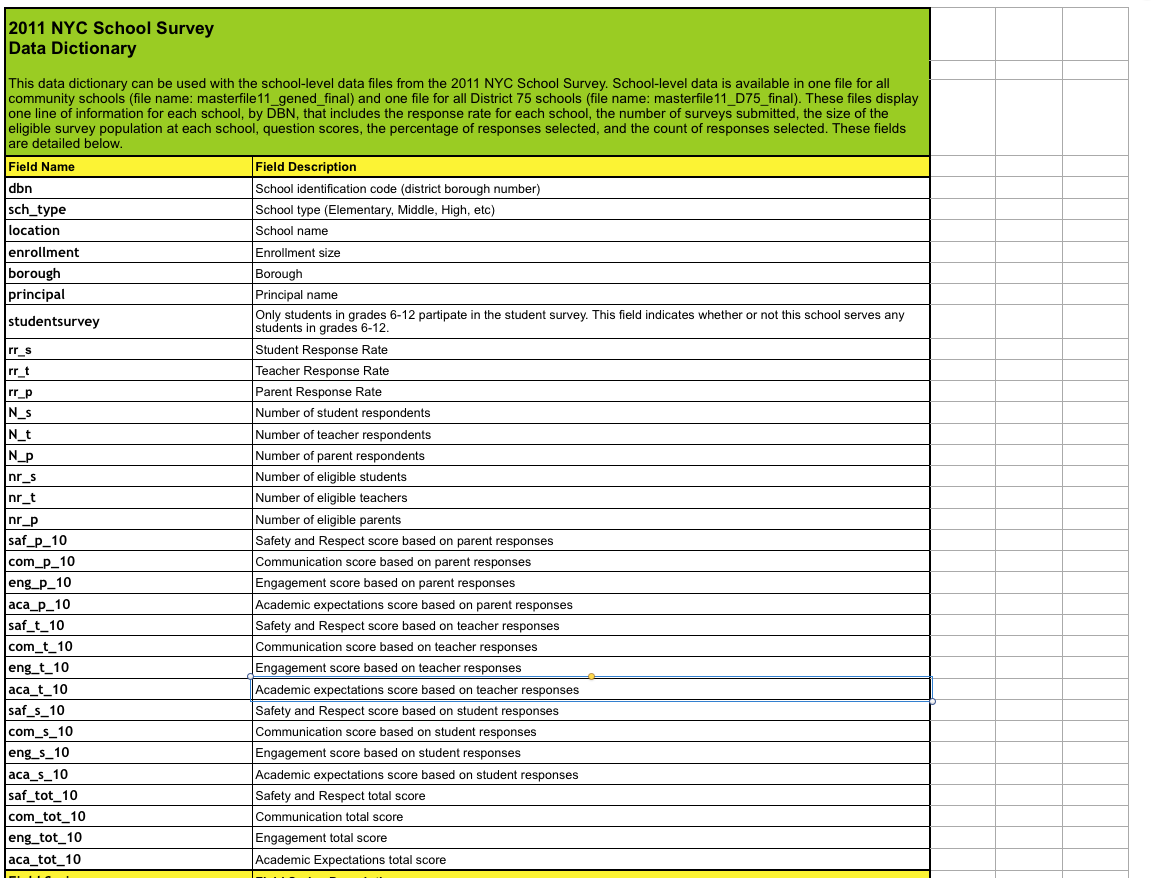

Based on the dictionary, it looks like these are the relevant columns:

["dbn", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

These columns will give us aggregate survey data about how parents, teachers, and students feel about school safety, academic performance, and more. It will also give us the DBN, which allows us to uniquely identify the school.

In [91]:
# Copy the data from the dbn column of survey into a new column in survey called DBN.
survey['DBN'] = survey['dbn']

survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", 
                 "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", 
                 "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

survey = survey.loc[:,survey_fields]

# Assign the dataframe survey to the key survey in the dictionary data.
data['survey'] = survey

print(data['survey'].shape)

(1702, 23)


When we explored all of the data sets, we noticed that some of them, like class_size and hs_directory, don't have a DBN column. hs_directory does have a dbn column, though, so we can just rename it.

In [92]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


In [93]:
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


**Adding DBN to the class_size dataframe**

In [94]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

def pad_csd(num):
    return str(num).zfill(2)

data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


**Combining the SAT scores**



In [95]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data['sat_results'][c] = pd.to_numeric(data['sat_results'][c], errors='coerce')

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

print(data['sat_results']['sat_score'].head())

0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64


**Parsing Geographic Coordinates for Schools**



In [96]:
data['hs_directory']['Location 1'].head()

0    883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...
1    1110 Boston Road\nBronx, NY 10456\n(40.8276026...
2    1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...
3    411 Pearl Street\nNew York, NY 10038\n(40.7106...
4    160-20 Goethals Avenue\nJamaica, NY 11432\n(40...
Name: Location 1, dtype: object

**Extracting the Latitude**

In [97]:
import re

def ext_lat(str_col):
    extracted = re.findall('\(.+\)', str_col)
    extracted_lat = extracted[0].split(',')[0].replace('(','')
    return extracted_lat

data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(ext_lat)
data['hs_directory'].head()

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,DBN,lat
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",17K548,40.67029890700047
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026...",09X543,40.8276026690005
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,"1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...",09X327,40.842414068000494
3,02M280,Manhattan Early College School for Advertising,Manhattan,M520,718-935-3477,NaN,9,10,9,14.0,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"411 Pearl Street\nNew York, NY 10038\n(40.7106...",02M280,40.71067947100045
4,28Q680,Queens Gateway to Health Sciences Secondary Sc...,Queens,Q695,718-969-3155,718-969-3552,6,12,NaN,NaN,...,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"160-20 Goethals Avenue\nJamaica, NY 11432\n(40...",28Q680,40.718810094000446


**Extracting the Longitude**

In [98]:
def find_lon(loc):
    coords = re.findall('\(.+\)', loc)
    lon = coords[0].split(',')[1].replace(')','').strip()
    return lon

data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(find_lon)

# Use the to_numeric() function to convert the lat and lon columns of hs_directory to numbers.

data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')


### Combining the Data

**Condensing the Class Size Data Set**

If we look at the unique values for GRADE, we get the following:

In [99]:
data['class_size']['GRADE '].unique()

array(['0K', '01', '02', '03', '04', '05', '0K-09', nan, '06', '07', '08',
       'MS Core', '09-12', '09'], dtype=object)

Because we're dealing with high schools, we're only concerned with grades 9 through 12. That means we only want to pick rows where the value in the GRADE column is 09-12.

Each school can have multiple program types. Because GEN ED is the largest category by far, let's only select rows where PROGRAM TYPE is GEN ED.




In [100]:
class_size = data['class_size']

class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']
class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


**Computing Average Class Sizes**

As we saw when we displayed class_size on the last screen, DBN still isn't completely unique. This is due to the CORE COURSE (MS CORE and 9-12 ONLY) and CORE SUBJECT (MS CORE and 9-12 ONLY) columns.

CORE COURSE (MS CORE and 9-12 ONLY) and CORE SUBJECT (MS CORE and 9-12 ONLY) seem to pertain to different kinds of classes. 
This column only seems to include certain subjects. We want our class size data to include every single class a school offers -- not just a subset of them. What we can do is take the average across all of the classes a school offers. This will give us unique DBN values, while also incorporating as much data as possible into the average.


In [101]:
import numpy as np

class_size = class_size.groupby('DBN').agg(np.mean)
#DBN becomes the index
class_size.reset_index(inplace=True)
data['class_size'] = class_size
data['class_size'].head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


**Condensing the Demographics Data Set**

Now that we've finished condensing class_size, let's condense demographics. The first few rows look like this:



In [102]:
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


In this case, the only column that prevents a given DBN from being unique is schoolyear. We only want to select rows where schoolyear is 20112012. This will give us the most recent year of data, and also match our SAT results data.



In [103]:
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]
data['demographics'].head()


,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


**Condensing the Graduation Data Set**

The Demographic and Cohort columns are what prevent DBN from being unique in the graduation data. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent Cohort available, which is 2006. We also want data from the full cohort, so we'll only pick rows where Demographic is Total Cohort.



Cohort column has '2006 Aug' values, converting them to 2006 below.

In [104]:
data['graduation']['Cohort'].value_counts()

graduation = data['graduation']

graduation['Cohort'].replace('2006 Aug', '2006', inplace=True)
print(graduation['Cohort'].value_counts())
graduation.info()

2006    8261
2005    3963
2004    3708
2003    3432
2002    3095
2001    2637
Name: Cohort, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25096 entries, 0 to 25095
Data columns (total 23 columns):
Demographic                           25096 non-null object
DBN                                   25096 non-null object
School Name                           25096 non-null object
Cohort                                25096 non-null object
Total Cohort                          25096 non-null int64
Total Grads - n                       25096 non-null object
Total Grads - % of cohort             25096 non-null object
Total Regents - n                     25096 non-null object
Total Regents - % of cohort           25096 non-null object
Total Regents - % of grads            25051 non-null object
Advanced Regents - n                  25096 non-null object
Advanced Regents - % of cohort        25096 non-null object
Advanced Regents - % of grads         25051 non-null object
Regents

In [105]:
data['graduation'] = graduation
data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1%,36,46.2%,83.7%,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,44,56.4%,37,47.4%,84.1%,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7%,42,33.9%,79.2%,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
11,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,60,48.4%,42,33.9%,70%,...,34,27.4%,56.7%,18,14.5%,30%,39,31.5%,20,16.100000000000001%
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8%,67,74.400000000000006%,95.7%,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%


**Converting AP Test Scores**

We're almost ready to combine all of the data sets. The only remaining thing to do is convert the Advanced Placement (AP) test scores from strings to numeric values. High school students take the AP exams before applying to college. There are several AP exams, each corresponding to a school subject. High school students who earn high scores may receive college credit.

It will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools. To determine this, we'll need to convert the AP exam scores in the ap_2010 data set to numeric values first.


In [106]:
data['ap_2010'].head()

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
0,01M448,UNIVERSITY NEIGHBORHOOD H.S.,39,49,10
1,01M450,EAST SIDE COMMUNITY HS,19,21,s
2,01M515,LOWER EASTSIDE PREP,24,26,24
3,01M539,"NEW EXPLORATIONS SCI,TECH,MATH",255,377,191
4,02M296,High School of Hospitality Management,s,s,s


In [107]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data['ap_2010'][col] = pd.to_numeric(data['ap_2010'][col], errors='coerce')

print(data['ap_2010'].dtypes)    

DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object


## Combining the Data

**Performing the Left Joins**

Both the ap_2010 and the graduation data sets have many missing DBN values, so we'll use a left join when we merge the sat_results data set with them. Because we're using a left join, our final dataframe will have all of the same DBN values as the original sat_results dataframe.



In [108]:
combined = data['sat_results']
combined = combined.merge(data['ap_2010'], on='DBN', how='left')
combined = combined.merge(data['graduation'], on='DBN', how='left')
combined.head()


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,36,46.2%,83.7%,7,9%,16.3%,16,20.5%,11,14.1%
1,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,NaN,NaN,NaN,...,37,47.4%,84.1%,7,9%,15.9%,15,19.2%,11,14.1%
2,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,34,27.4%,64.2%,11,8.9%,20.8%,46,37.1%,20,16.100000000000001%
3,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.0,49.0,...,34,27.4%,56.7%,18,14.5%,30%,39,31.5%,20,16.100000000000001%
4,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.0,21.0,...,67,74.400000000000006%,95.7%,3,3.3%,4.3%,15,16.7%,5,5.6%


**Performing the Inner Joins**

Now that we've performed the left joins, we still have to merge class_size, demographics, survey, and hs_directory into combined. Because these files contain information that's more valuable to our analysis and also have fewer missing DBN values, we'll use the inner join type.

In [109]:
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")


print(combined.shape)

(673, 159)


**Filling in Missing Values**



In [110]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,130.519512,199.287805,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,130.519512,199.287805,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
2,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
3,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
4,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041


**Adding a School District Column**

In [111]:
def dist(two):
    fist_two = two[0:2]
    return fist_two

combined['school_dist'] = combined['DBN'].apply(dist)
print(combined['school_dist'].head())

0    01
1    01
2    01
3    01
4    01
Name: school_dist, dtype: object


In [112]:
# blocking info warnings:
import warnings
warnings.filterwarnings('ignore')

# Analyzing and Visualizing the Data

**Finding Correlations With the r Value**

In [113]:
correlations = combined.corr()
correlations = correlations['sat_score']
correlations

SAT Critical Reading Avg. Score         0.986764
SAT Math Avg. Score                     0.972775
SAT Writing Avg. Score                  0.988067
sat_score                               1.000000
AP Test Takers                          0.527545
Total Exams Taken                       0.518337
Number of Exams with scores 3 4 or 5    0.467244
Total Cohort                            0.328468
CSD                                     0.039493
NUMBER OF STUDENTS / SEATS FILLED       0.400433
NUMBER OF SECTIONS                      0.369221
AVERAGE CLASS SIZE                      0.396027
SIZE OF SMALLEST CLASS                  0.263865
SIZE OF LARGEST CLASS                   0.324029
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.738883
total_enrollment                        0.370521
ell_num                                -0.148718
ell_percent         

**Plotting Survey Correlations**


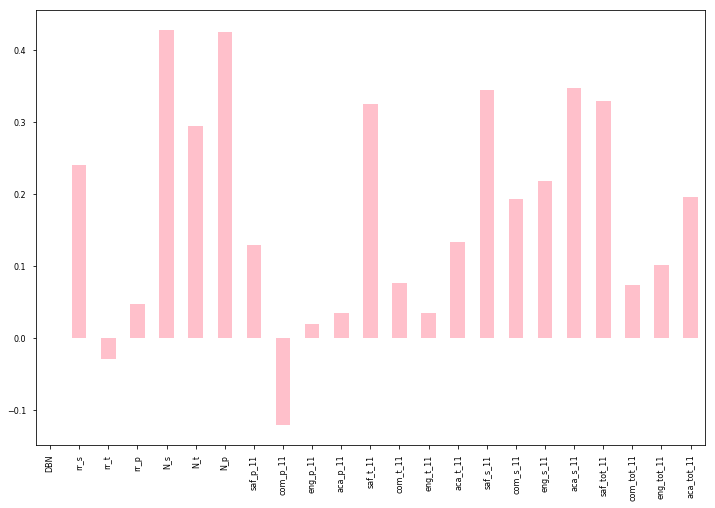

In [114]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
%matplotlib inline

combined.corr()['sat_score'][survey_fields].plot.bar(figsize=(12,8), color = 'pink')

**Plotting Enrollment With the Plot( ) Accessor**

Scatterplot of total_enrollment versus sat_score.

<function matplotlib.pyplot.show(*args, **kw)>

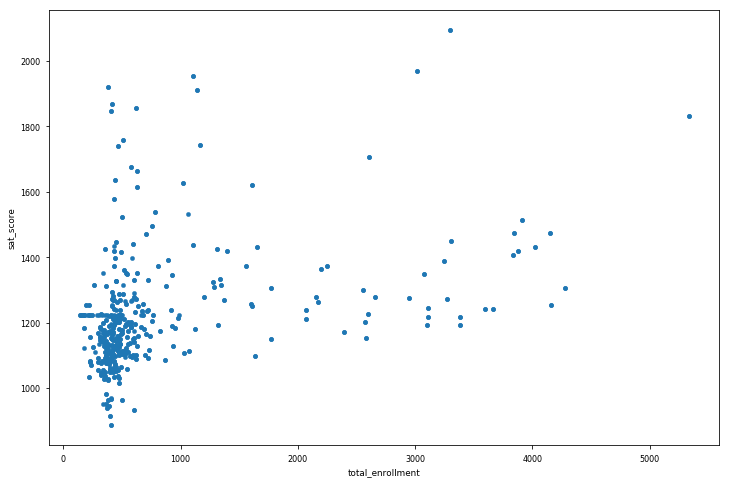

In [115]:
combined.plot.scatter(x='total_enrollment', y='sat_score', figsize = (12, 8))
plt.show

**Exploring Schools With Low SAT Scores and Enrollment**

Judging from the plot we just created, it doesn't appear that there's an extremely strong correlation between sat_score and total_enrollment. If there was a very strong correlation, we'd expect all of the points to line up. Instead, there's a large cluster of schools, and then a few others going off in three different directions.

However, there's an interesting cluster of points at the bottom left where total_enrollment and sat_score are both low. This cluster may be what's making the r value so high. It's worth extracting the names of the schools in this cluster so we can research them further.

In [116]:
low_enrollment = combined[combined['total_enrollment'] < 1000]
low_enrollment = low_enrollment[low_enrollment['sat_score'] < 1000]
print(low_enrollment['School Name'])

166      INTERNATIONAL COMMUNITY HIGH SCHOOL
167      INTERNATIONAL COMMUNITY HIGH SCHOOL
228                                        0
229          BRONX INTERNATIONAL HIGH SCHOOL
230          BRONX INTERNATIONAL HIGH SCHOOL
255    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
256    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
259    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
260    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
329                                        0
332            HIGH SCHOOL OF WORLD CULTURES
333            HIGH SCHOOL OF WORLD CULTURES
350       BROOKLYN INTERNATIONAL HIGH SCHOOL
351       BROOKLYN INTERNATIONAL HIGH SCHOOL
418    INTERNATIONAL HIGH SCHOOL AT PROSPECT
419    INTERNATIONAL HIGH SCHOOL AT PROSPECT
442               IT TAKES A VILLAGE ACADEMY
443               IT TAKES A VILLAGE ACADEMY
470                MULTICULTURAL HIGH SCHOOL
471                MULTICULTURAL HIGH SCHOOL
532    PAN AMERICAN INTERNATIONAL HIGH SCHOO
533    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: Scho

**Googled Bronx International High School, found info below:**

What’s Special: A school for new immigrants learning English

The Downside: Metal detectors

**Plotting Language Learning Percentage**

Our research on the last screen revealed that most of the high schools with low total enrollment and low SAT scores have high percentages of English language learners. This indicates that it's actually ell_percent that correlates strongly with sat_score, rather than total_enrollment. To explore this relationship further, let's plot out ell_percent vs sat_score.

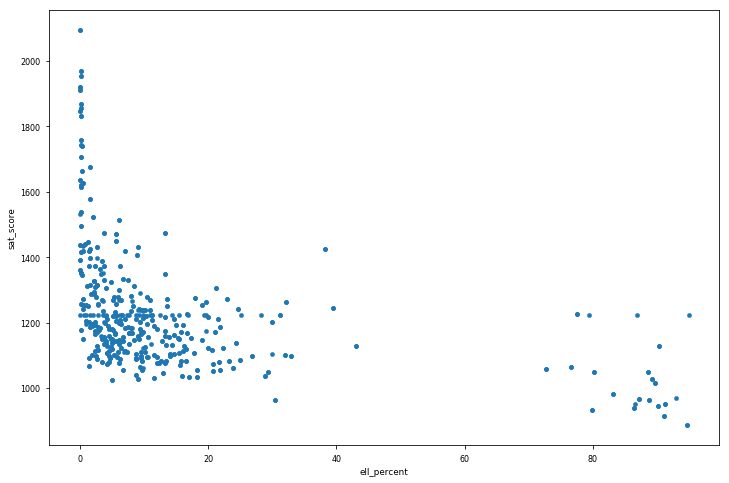

In [117]:
combined.plot.scatter(x='ell_percent', y='sat_score', figsize = (12,8))
plt.show()

### Picture of New York boroughs for reference

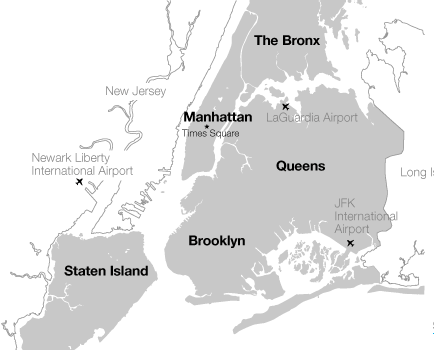

**Mapping the Schools**

It looks like ell_percent correlates with sat_score more strongly, because the scatterplot is more linear. However, there's still the cluster of schools that have very high ell_percent values and low sat_score values. This cluster represents the same group of international high schools we investigated earlier.

In order to explore this relationship, we'll want to map out ell_percent by school district. The map will show us which areas of the city have a lot of English language learners.


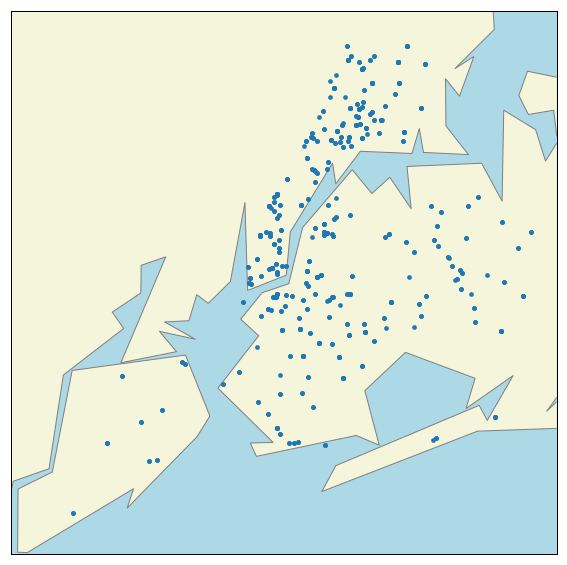

In [118]:
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(10,10))

m = Basemap(
    projection='merc',
    llcrnrlat=40.496044,
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='LightBlue')
m.drawcoastlines(color='grey', linewidth=1)
m.fillcontinents(color='beige', lake_color='#85A6D9')

longitudes = combined['lon'].tolist()
latitudes = combined['lat'].tolist()
m.scatter(longitudes, latitudes, s=80, zorder=2, latlon=True, marker = '.')

plt.show()

**Plotting Out Statistics**

From the map on the previous screen, we can see that school density is highest in Manhattan (the top of the map), and lower in Brooklyn, the Bronx, Queens, and Staten Island.

Now that we've plotted the school locations, we can begin to display meaningful information on the maps, such as the percentage of English language learners by area.



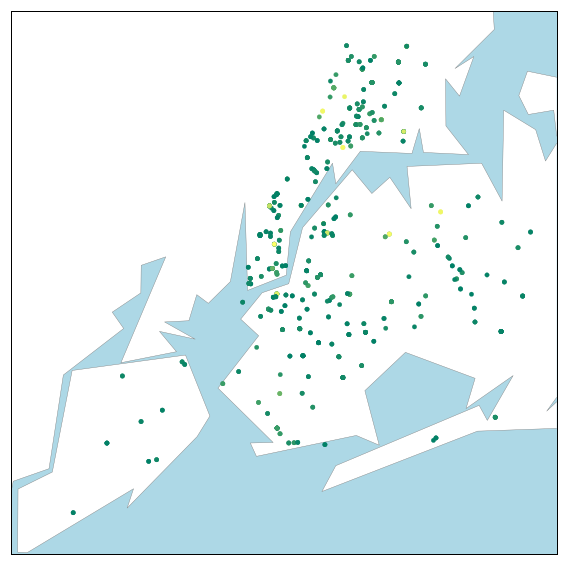

In [119]:
plt.figure(figsize=(10,10))

m = Basemap(
    projection='merc',
    llcrnrlat=40.496044,
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='LightBlue')
m.drawcoastlines(color='grey', linewidth=.4)
m.fillcontinents(color='white', lake_color='#85A6D9')

longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()
m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=combined["ell_percent"], cmap="summer")
plt.show()

**Yellow markers in above show higher percentage of English learners.**

**Calculating District-Level Statistics**

Unfortunately, due to the number of schools, it's hard to interpret the map we made on the last screen. It looks like uptown Manhattan and parts of Queens have a higher ell_percent, but we can't be sure. One way to make very granular statistics easier to read is to aggregate them. In this case, we can aggregate by district, which will enable us to plot ell_percent district-by-district instead of school-by-school.



In [120]:
districts = combined.groupby('school_dist').agg(np.mean)

districts.reset_index(inplace=True)
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,117.426423,174.143902,136.351319,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,427.632389,445.414718,425.942983,1298.990090,129.485201,202.753631,158.195013,155.877492,2.0,...,12.0,12.0,10024.786517,639.370787,1.449438,0.0,0.0,0.0,40.739556,-73.991205
2,03,432.054348,440.640713,430.855368,1303.550429,160.843554,252.484088,199.340699,181.886329,3.0,...,12.0,12.0,10023.714286,761.047619,2.142857,0.0,0.0,0.0,40.780979,-73.977792
3,04,402.142857,416.285714,405.714286,1224.142857,129.868293,185.164460,151.626413,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,435.198370,445.818194,427.832298,1308.848861,88.213211,117.738618,141.184652,135.311828,5.0,...,12.0,12.0,10030.666667,630.416667,1.166667,0.0,0.0,0.0,40.817744,-73.948116


**Plotting Percent Of English Learners by District**

Now that we've taken the means of all of the columns, we can plot out ell_percent by district. Not only did we find the mean of ell_percent, but we also took the means of the lon and lat columns, which will give us the coordinates for the center of each district.

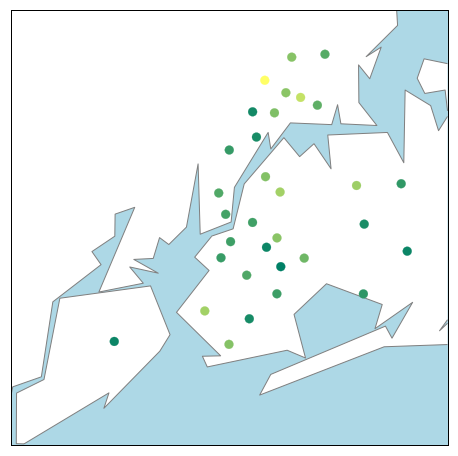

In [121]:
plt.figure(figsize=(8,8))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
m.drawmapboundary(fill_color='LightBlue')
m.drawcoastlines(color='grey', linewidth=1)
m.fillcontinents(color='white',lake_color='#85A6D9')


longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=80, zorder=2, latlon=True, c=districts["ell_percent"], cmap="summer")
plt.show()

**Plotting survey correlations**



In [122]:
#Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")



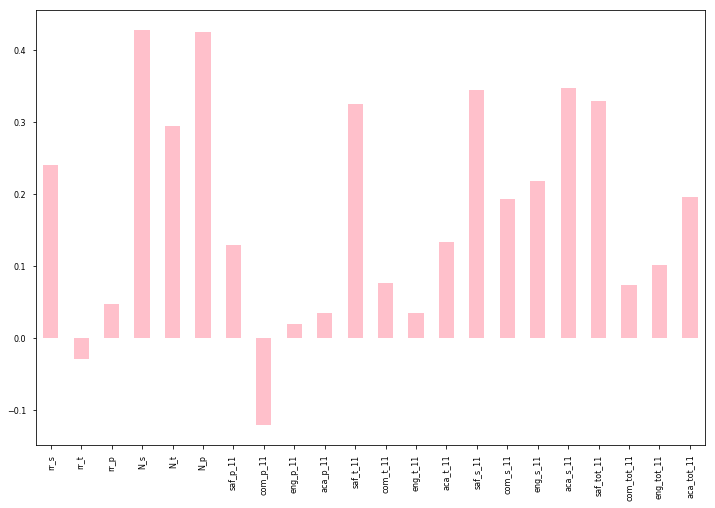

In [123]:

combined.corr()['sat_score'][survey_fields].plot.bar(figsize=(12,8), color = 'pink')

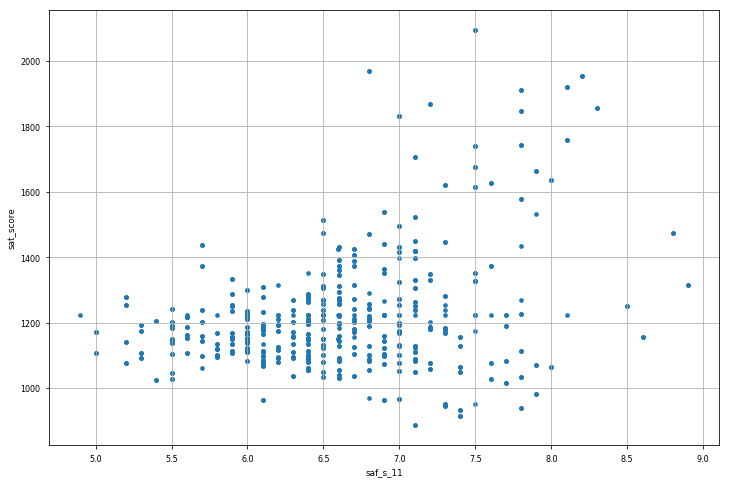

In [124]:

combined.plot.scatter(x='saf_s_11', y='sat_score', figsize=(12,8), grid=True)

plt.show()

Some correlation between safety and sat. If safety is below 6.5 sat_score is below 1600 for all schools. 

**Lets plot safety on map**

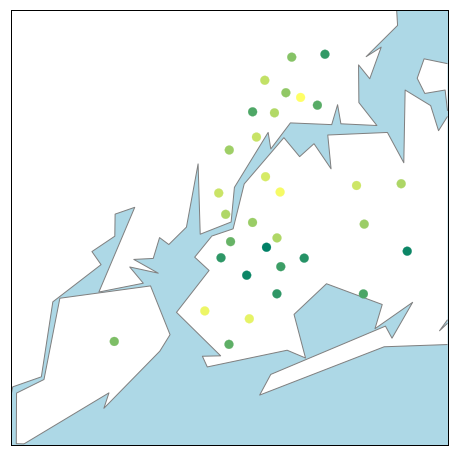

In [125]:
plt.figure(figsize=(8,8))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
m.drawmapboundary(fill_color='LightBlue')
m.drawcoastlines(color='grey', linewidth=1)
m.fillcontinents(color='white',lake_color='#85A6D9')


longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=80, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

Over all Manhattan seems to be most safe. 

**Investigate racial differences in SAT scores.**

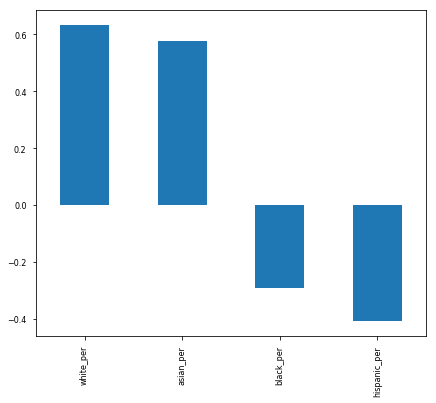

In [126]:
race_cols = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_cols].plot.bar(figsize = (7,6))

White and asian students correlate positively with SAT scores where as black and hispanic students correlate negatively.

Can this be due to low funding to some schools? We will need to collect and explore school funding data.

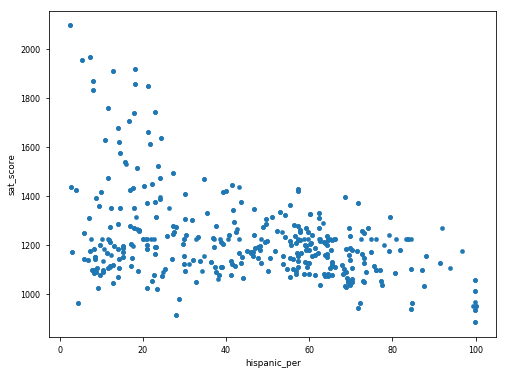

In [127]:
combined.plot.scatter(x='hispanic_per', y='sat_score', figsize=(8,6))
plt.show()

**Exploring Gender and SAT Scores**

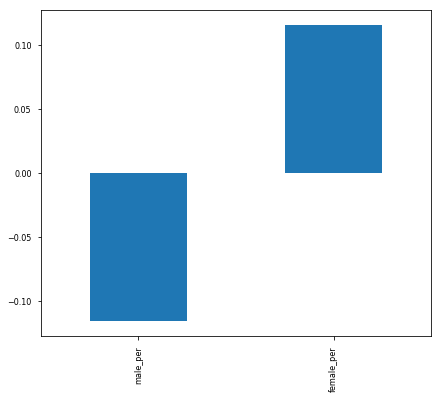

In [128]:
gender_cols = ['male_per', 'female_per']
combined.corr()['sat_score'][gender_cols].plot.bar(figsize=(7,6))

We can see above that higher number of females per school correlates positively to SAT scores whereas higher male percent correlates negatively to SAT score.

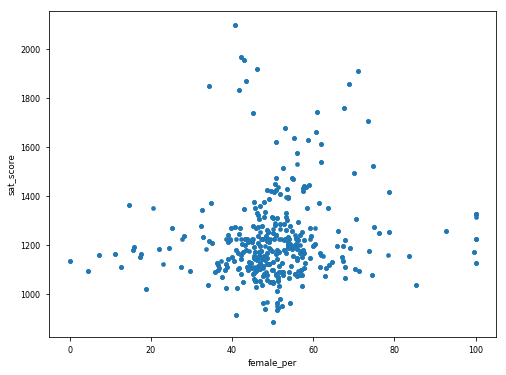

In [129]:
combined.plot.scatter(x='female_per', y='sat_score', figsize=(8,6))
plt.show()

Well based on the scatter plot there doesnt seem to much of positive correlation. There are some schools with high percent of females and high SAT score.